# Predictive Modelling

## Exercise 1: Face Recognition (but not as evil this time)

Using the faces dataset in:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
```

If you use the `faces.target` and `faces.target_names` attributes, you can build a facial recognition algorithm.

Use sklearn **gridsearch** (or an equivalent, like random search) to optimize the model for accuracy. Try both a SVM-based classifier and a logistic regression based classifier (with a feature pipeline of your choice) to get the best model. You should have at least 75-80% accuracy.

In [35]:
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_lfw_pairs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from time import time
import lightgbm as lgbm
from sklearn.cluster import KMeans

In [36]:
# exercise 1
faces = fetch_lfw_people(min_faces_per_person=60)


In [74]:
# faces.DESCR #to see description of data

In [38]:
x = faces.data
y = faces.target.astype(float)
names = [faces.target_names[int(y[i])] for i in range(len(y))]
x.shape

(1277, 2914)

In [75]:
# df = pd.concat([pd.DataFrame(x), pd.Series(y, name='y'), pd.Series(names, name='names')], axis=1)
# df

In [40]:
names[:6]

['Donald Rumsfeld',
 'George W Bush',
 'George W Bush',
 'Ariel Sharon',
 'Ariel Sharon',
 'Colin Powell']

In [41]:
names_unique = faces.target_names
names_unique

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Junichiro Koizumi', 'Tony Blair'],
      dtype='<U17')

In [42]:
n_images, h, w = faces.images.shape
n_images, h, w

(1277, 62, 47)

In [43]:
faces.data.dtype

dtype('float32')

In [44]:
faces.data.shape,   faces.target.shape

((1277, 2914), (1277,))

In [45]:
#faces_train = fetch_lfw_pairs(subset='train')

In [46]:
list(faces.target[:10])

[2, 3, 3, 0, 0, 1, 1, 3, 4, 1]

In [47]:
#faces.images #image data , each row for one picture

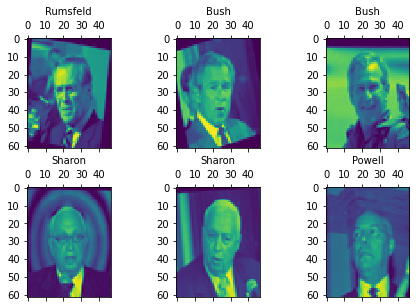

In [48]:
   
# def true_title(Y, names, i):
#     true_name = names[i].rsplit(' ', 1)[-1]
#     return 'true label:   % s' % (true_name)
 
# true_titles = [true_title(y, names, i)
#                      for i in range(y.shape[0])]

fig, axs = plt.subplots(2, 3)
plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)#frame adjustment
for i, ax in enumerate(axs.flat):
    ax.matshow(faces.images[i])
    ax.set_title(names[i].rsplit(' ')[-1], size=10)#labeling the picture


In [49]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=101)

In [50]:
t0 = time()
steps = [ ('pca', PCA()),
        
         ('log_reg',LogisticRegression(solver='saga'))
         ]#dimension reduction is 500
model = Pipeline(steps=steps)
param_grid = [{
              'pca__svd_solver':['full', 'arpack', 'randomized'],
              'pca__tol':[0.001, 0.01, 0.1],
              'pca__n_components' : [2, 50, 100, 150],
              'log_reg__tol':[0.0001, .001, .01], 
              'log_reg__C': [0.001, 0.01, 0.1, 1]
             }]

grid = GridSearchCV(model, param_grid=param_grid, scoring='accuracy' ,cv = 3, n_jobs = -1, verbose = 3,  error_score='raise')
grid.fit(xtrain, ytrain)
grid.best_params_

print ("done in %0.3fs" % (time() - t0))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
done in 224.122s


In [51]:
grid.best_params_

{'log_reg__C': 1,
 'log_reg__tol': 0.01,
 'pca__n_components': 150,
 'pca__svd_solver': 'full',
 'pca__tol': 0.001}

In [52]:
#according to grid.best_params_, model will be fitted on data
steps = [ ('pca', PCA(n_components=150, svd_solver='randomized', tol= 0.01 )),
        
         ('log_reg',LogisticRegression(solver='saga', tol= 0.01, C= 1))
         ]#dimension reduction is 500
model = Pipeline(steps=steps)
model.fit(xtrain, ytrain)


Pipeline(steps=[('pca',
                 PCA(n_components=150, svd_solver='randomized', tol=0.01)),
                ('log_reg', LogisticRegression(C=1, solver='saga', tol=0.01))])

In [60]:
ypred = model.predict(xtest)
names_pred = [faces.target_names[int(ypred[i])] for i in range(len(ypred))]

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))

[[ 8  1  0  1  0  0  0]
 [ 1 44  1  3  0  1  0]
 [ 1  5 14  6  0  0  1]
 [ 0  2  2 92  0  0  1]
 [ 0  1  0  3 23  0  2]
 [ 0  0  0  0  0  9  1]
 [ 1  3  2  2  0  1 24]]
              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76        10
         1.0       0.79      0.88      0.83        50
         2.0       0.74      0.52      0.61        27
         3.0       0.86      0.95      0.90        97
         4.0       1.00      0.79      0.88        29
         5.0       0.82      0.90      0.86        10
         6.0       0.83      0.73      0.77        33

    accuracy                           0.84       256
   macro avg       0.82      0.80      0.80       256
weighted avg       0.84      0.84      0.83       256



In [79]:
pd.DataFrame(ytest[:10], ypred[:10]).head(5)

,0
3.0,3.0
2.0,3.0
1.0,1.0
6.0,6.0
1.0,1.0


In [72]:
pred_log_names = [faces.target_names[int(ypred[i])] for i in range(len(ypred))]
test_names = [faces.target_names[int(ytest[i])] for i in range(len(ytest))]
pd.concat([pd.Series(pred_log_names, name='pred_log_names'), pd.Series(test_names, name='true_names')], axis=1)

,pred_log_names,true_names
0,George W Bush,George W Bush
1,Donald Rumsfeld,George W Bush
2,Colin Powell,Colin Powell
3,Tony Blair,Tony Blair
4,Colin Powell,Colin Powell
...,...,...
251,George W Bush,George W Bush
252,George W Bush,George W Bush
253,Gerhard Schroeder,Gerhard Schroeder
254,George W Bush,George W Bush


In [17]:
t0 = time()
steps = [ ('kmeans', KMeans()),
        
         ('svc', SVC())
         ]#dimension reduction is 500
model = Pipeline(steps=steps)
param_grid = [{     
                    'kmeans__tol' :[.0001,.001, 0.1],
                    'kmeans__n_clusters' : [7, 10, 14],
                    'svc__C':[ 0.01, 0.1, 1],
                    'svc__kernel':['linear', 'rbf'],
#                     'svc__coef0' :['poly' , 'sigmoid'],
                    'svc__tol' :[.0001,.001, 0.1] }] 
                
               
grid = GridSearchCV(model, param_grid=param_grid, scoring='accuracy' ,cv = 3, n_jobs = -1, verbose = 3,  error_score='raise')
grid.fit(xtrain, ytrain)

print ("done in %0.3fs" % (time() - t0))

Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\zmaso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


done in 344.485s


In [18]:
grid.best_params_


{'kmeans__n_clusters': 14,
 'kmeans__tol': 0.1,
 'svc__C': 1,
 'svc__kernel': 'linear',
 'svc__tol': 0.0001}

In [27]:
#pipeline with kmeans
t0 = time()
steps = [
         ('kmeans', KMeans(n_clusters= 14, tol= 0.1 )),
         ('svc', SVC(C= 1, kernel= 'linear', tol= 0.0001 ))
    
         ] #pipeline with the best parameters from gridsearch result
model = Pipeline(steps=steps)
model.fit(xtrain, ytrain)

print ("done in %0.3fs" % (time() - t0))

C:\Users\zmaso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


done in 17.631s


In [28]:
ypred = model.predict(xtest)
names_pred = [faces.target_names[int(ypred[i])] for i in range(len(ypred))]

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))

[[ 3  0  0  7  0  0  0]
 [ 0  0  0 50  0  0  0]
 [ 1  0  0 26  0  0  0]
 [ 3  0  0 94  0  0  0]
 [ 0  0  0 29  0  0  0]
 [ 0  0  0 10  0  0  0]
 [ 0  0  0 33  0  0  0]]
              precision    recall  f1-score   support

         0.0       0.43      0.30      0.35        10
         1.0       0.00      0.00      0.00        50
         2.0       0.00      0.00      0.00        27
         3.0       0.38      0.97      0.54        97
         4.0       0.00      0.00      0.00        29
         5.0       0.00      0.00      0.00        10
         6.0       0.00      0.00      0.00        33

    accuracy                           0.38       256
   macro avg       0.12      0.18      0.13       256
weighted avg       0.16      0.38      0.22       256



C:\Users\zmaso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmaso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zmaso\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
#pipeline with PCA and SVC

t0 = time()
steps = [ ('pca', PCA()),
        
         ('svc',SVC())
         ]
model2 = Pipeline(steps=steps)
param_grid = [{
              'pca__svd_solver':['full', 'arpack', 'randomized'],
              'pca__tol':[0.001, 0.01, 0.1],
              'pca__n_components' : [2, 50, 100, 150],
              'svc__C':[ 0.01, 0.1, 1],
              'svc__kernel':['linear', 'rbf'],
#             'svc__coef0' :['poly' , 'sigmoid'],
              'svc__tol' :[.0001,.001, 0.1] }]  

grid = GridSearchCV(model2, param_grid=param_grid, scoring='accuracy' ,cv = 3, n_jobs = -1, verbose = 3,  error_score='raise')
grid.fit(xtrain, ytrain)
grid.best_params_

print ("done in %0.3fs" % (time() - t0))

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
done in 381.031s


In [30]:
grid.best_params_

{'pca__n_components': 150,
 'pca__svd_solver': 'randomized',
 'pca__tol': 0.001,
 'svc__C': 0.1,
 'svc__kernel': 'linear',
 'svc__tol': 0.1}

In [32]:
t0 = time()
steps = [ ('pca', PCA(n_components = 150, svd_solver = 'randomized', tol = 0.001)),
        
         ('svc',SVC( C = 0.1, kernel = 'linear', tol = 0.1))
         ]
model2 = Pipeline(steps=steps)

model2.fit(xtrain, ytrain)

print ("done in %0.3fs" % (time() - t0))

done in 0.169s


In [34]:
ypred2 = model2.predict(xtest)
# names_pred2 = [faces.target_names[int(ypred[i])] for i in range(len(ypred))]

print(confusion_matrix(ytest, ypred2))
print(classification_report(ytest, ypred2))

[[10  0  0  0  0  0  0]
 [ 3 43  1  3  0  0  0]
 [ 2  5 17  2  0  0  1]
 [ 0  3  1 93  0  0  0]
 [ 0  1  0  4 18  0  6]
 [ 0  0  0  0  0 10  0]
 [ 1  1  3  6  0  0 22]]
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77        10
         1.0       0.81      0.86      0.83        50
         2.0       0.77      0.63      0.69        27
         3.0       0.86      0.96      0.91        97
         4.0       1.00      0.62      0.77        29
         5.0       1.00      1.00      1.00        10
         6.0       0.76      0.67      0.71        33

    accuracy                           0.83       256
   macro avg       0.83      0.82      0.81       256
weighted avg       0.84      0.83      0.83       256



In [80]:
#in this tabel, we could compare and see the predictions for each predicted label.

pred_svc_names = [faces.target_names[int(ypred2[i])] for i in range(len(ypred2))]
# test_names = [faces.target_names[int(ytest[i])] for i in range(len(ytest))]
pd.concat([pd.Series(test_names, name='true_names'),
           pd.Series(pred_log_names, name='pred_log_names'),
           pd.Series(pred_svc_names, name='pred_svc_names')],
           axis=1)

,true_names,pred_log_names,pred_svc_names
0,George W Bush,George W Bush,George W Bush
1,George W Bush,Donald Rumsfeld,George W Bush
2,Colin Powell,Colin Powell,Colin Powell
3,Tony Blair,Tony Blair,Colin Powell
4,Colin Powell,Colin Powell,Colin Powell
...,...,...,...
251,George W Bush,George W Bush,George W Bush
252,George W Bush,George W Bush,George W Bush
253,Gerhard Schroeder,Gerhard Schroeder,Gerhard Schroeder
254,George W Bush,George W Bush,George W Bush


In [67]:
# it is clear PCA could improve the fitting and accuracy in both pipelines' modeles. 
# however logisticregression could achieve 1% more accuracy, SVC has 2 labels with 
# acuracy equal 1 approved in confusion matrix.
# kmeans not only could not improve the accuracy score, but also it has the too low prediction an dfitting.
# I could not use any other classifiers or algorithms because of transforming problem,
# like lgbmclassifier has not transform in its implementation which is necessary for pipeline implementation.